# E-Ticaret Ürün Verilerini Toplama ve Analiz Etme
Bu notebook, Trendyol üzerindeki 'Gıda ve İçecek' kategorisindeki ürün verilerini toplayacak, temizleyecek, PostgreSQL veritabanına aktaracak ve analiz edecektir.

### Kütüphaneleri Yükleme

In [104]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup


## 1. Web Scraping
TrendYol sitesindeki 'Gıda ve İçecek' kategorisindeki ilk 200 ürünün verilerini toplayacağız.

### Ürün verilerini Toplama

In [113]:
def extract_product_details_updated(item, productid):
    # Ürün detaylarını kazıyan fonksiyon
    try:
        # Ürün markası
        brand = item.find_element(By.CLASS_NAME, 'prdct-desc-cntnr-ttl').text.strip()
    except:
        brand = None

    try:
        # Ürün adı
        name = item.find_element(By.CLASS_NAME, 'prdct-desc-cntnr-name').text.strip()
    except:
        name = None

    try:
        # Ürün fiyatı
        price = item.find_element(By.CLASS_NAME, 'prc-box-dscntd').text.strip()
    except:
        price = None

    try:
        # Ürün açıklaması
        description = item.find_element(By.CLASS_NAME, 'product-desc-sub-text').text.strip()
    except:
        description = None

    try:
        # Ürün yorum sayısı
        comment_count = int(item.find_element(By.CLASS_NAME, 'ratingCount').text.strip('()'))
    except:
        comment_count = 0

    try:
        # Ürün yıldız değerlendirmesini hesaplıyoruz
        full_stars = item.find_elements(By.CLASS_NAME, 'full')
        # Her bir yıldızın genişliğini alıp toplayarak toplam genişliği buluyoruz
        total_width = sum([float(star.get_attribute('style').split('width:')[1].split('%')[0].strip()) for star in full_stars])
        # Yıldız sayısına bölerek ortalama puanı hesaplıyoruz
        rating_score = round((total_width / len(full_stars)) * 5 / 100, 1) if full_stars else None
    except:
        rating_score = None

    # Ürün detaylarını bir sözlük olarak döndürüyoruz
    return {
        'productid': productid,
        'brand': brand,
        'name': name,
        'price': price,
        'category': "Gıda ve İçecek",
        'description': description,
        'comment_count': comment_count,
        'rating_score': rating_score
    }


In [114]:
# Driver'ı başlat 
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Tarayıcıyı headless modda çalıştır
driver = webdriver.Chrome(options=options)

# Kazınacak URL
url = 'https://www.trendyol.com/gida-ve-icecek-x-c103946'
driver.get(url)  # Belirtilen URL'yi aç

# Benzersiz ürün verilerini toplamak için liste ve ID listesi oluştur
products = []
data_ids = []

# Başlangıç kaydırma pozisyonu
scroll_position = 0

# Ürün sayısı 300'e ulaşana kadar kaydır ve veri topla
while len(products) < 300:
    # Ürün kartlarını seç
    items = driver.find_elements(By.CLASS_NAME, 'p-card-wrppr')
    for item in items:
        productid = item.get_attribute('data-id')  # Ürün ID'sini al
        if productid not in data_ids:  # Eğer ID listede yoksa
            data_ids.append(productid)  # ID'yi listeye ekle
            product_details = extract_product_details_updated(item, productid)  # Ürün detaylarını çıkar
            products.append(product_details)  # Ürün detaylarını ürünler listesine ekle
            
    # Kaydırma pozisyonunu artır
    scroll_position += 1000
    driver.execute_script(f'window.scrollTo(0, {scroll_position});')  # Sayfayı kaydır
    time.sleep(2)  # 2 saniye bekle

# Tarayıcıyı kapat
driver.quit()

# Veriyi DataFrame'e dönüştür
df = pd.DataFrame(products)

# DataFrame'i CSV dosyasına kaydet
df.to_csv('trendyol_product_data.csv', index=False)

## 2. Veri Temizleme ve Dönüştürme
Toplanan verilerin temizlenmesi ve yapılandırılmış bir formata dönüştürülmesi.

In [115]:
df['price'] = df['price'].str.replace(' TL', '').str.replace('.', '').str.replace(',', '.').str.replace('"', '').astype(float)

# Boş olan brand, name ve price sütunlarını temizleme
df = df.dropna(subset=['brand', 'name', 'price'])

# Brand değişkeninde bazı verilerin ilk harfini büyük yapma
df['brand'] = df['brand'].str.title()


C:\Users\bulut\AppData\Local\Temp\ipykernel_32460\1637785579.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace(' TL', '').str.replace('.', '').str.replace(',', '.').str.replace('"', '').astype(float)


In [116]:
df.head()

,productid,brand,name,price,category,description,comment_count,rating_score
0,815909040,Melek Ana,Kids Çocuklar için,389.0,Gıda ve İçecek,"Özel Kakaolu, Arı sütlü, Vitaminli, İştah Açıc...",578,5.0
1,37808818,Kb Köyceğiz Yöresel,Karadut,290.0,Gıda ve İçecek,Özü 1000 G,27224,4.8
2,829692875,Setamell,Kilo Aldırıcı Iştah,374.0,Gıda ve İçecek,Açıcı ( Çikolata Aromalı Toz ),141,5.0
3,279296582,Antebella,Antep Fıstık,185.0,Gıda ve İçecek,Kreması 200 gr,393,4.7
4,829926931,Doree Beaute,Kilo aldırıcı,305.0,Gıda ve İçecek,iştah açıcı çikolata aromalı toz 230 gr,324,5.0


## 3. Veritabanı
Temizlenen verilerin PostgreSQL veritabanına aktarılması.

### Database Connection 

In [117]:
# Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# .env dosyasını yükleme
load_dotenv()

# Veritabanı bağlantı bilgilerini alma
DB_HOST = os.getenv('DB_HOST')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')


### Veritabanına Aktarma

In [118]:
# Veritabanı bağlantısı
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD
)
cur = conn.cursor()

# Verilerin tabloya aktarılması
for index, row in df.iterrows():
    cur.execute(
        '''
        INSERT INTO product_information (productid, brand, name, price, description, comment_count, rating_score)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        ''',
        (row['productid'], row['brand'], row['name'], row['price'], row['description'], row['comment_count'], row['rating_score'])
    )

conn.commit()
cur.close()
conn.close()


## 4. Veri Analizi


### # Analiz 1: En pahalı ürünler

In [119]:
most_expensive = df.nlargest(10, 'price')

most_expensive

,productid,brand,name,price,category,description,comment_count,rating_score
164,780256333,Gelincik,5 Kg Antep Fıstığı,3599.00,Gıda ve İçecek,Kreması,2,5.0
125,2946176,Mehmet Efendi,Kurukahveci 100,1058.75,Gıda ve İçecek,gr 25'li Paket Türk Kahvesi,11786,4.8
11,829616962,Sheby'S,Çıtır Çıtır Kadayıflı,920.00,Gıda ve İçecek,Künefe Gerçek Dubaı Çikolatası 2’li,9,4.8
231,742686203,Stayfi̇t,90 Günlük Bromelain,799.00,Gıda ve İçecek,Ekstreli Detox Tea 560 gr,23,4.6
223,466453791,Hilay,Sürülebilir Antep,780.00,Gıda ve İçecek,Fısıtğı Ezmesi Avantajlı Paket 2x320 Gr,4,4.2
97,822618200,Nutripharma,QUICK SLIM COFFEE,770.00,Gıda ve İçecek,"LUX,Biyoaktif Kolajen Peptidleri,L-Karnitin,Pr...",6,4.7
256,345725760,Plantero,3'lü Badem Sütü Bazı,740.00,Gıda ve İçecek,"Konsantre Bitkisel Süt (250GR, %100 BADEM, ŞEK...",90,4.8
165,809996518,Wefood,Karadut Özü 700 gr,716.00,Gıda ve İçecek,(Soğuk Sıkım) 4'lü,1,NaN
166,34585010,Tchibo,Barista Caffè Crema,699.90,Gıda ve İçecek,Çekirdek Kahve 1000 g,3852,4.8
277,694961344,Narcissa,2 Adet - Aserola,689.00,Gıda ve İçecek,Ekstresi Içeren Karışık Bitki Tozu,3964,4.2


### # Analiz 2: En ucuz ürünler

In [120]:
cheapest = df.nsmallest(10, 'price')

cheapest

,productid,brand,name,price,category,description,comment_count,rating_score
258,807287538,Keyifçe,Antep Fıstık ezmesi,16.90,Gıda ve İçecek,(25gr),55,4.6
24,176804799,Seed'N Grains,Glutensiz,44.63,Gıda ve İçecek,Karabuğday Patlağı 125 gr,1783,4.7
89,299356355,Seed'N Grains,Rice Cake,44.90,Gıda ve İçecek,Pirinç Patlağı 135 gr,1572,4.8
198,224808037,Fondante,Sütlü Fondan 200 Gr.,49.99,Gıda ve İçecek,(1 Paket),3294,4.7
47,379180974,Elvan,Maxim Crown Kakaolu,50.99,Gıda ve İçecek,Bisküvi 275 Gr. (1 Poşet),5125,4.6
242,311004287,Elvan,Fondante Caramel Toffee,56.57,Gıda ve İçecek,200 Gr. (1 Adet),4134,4.6
159,200345623,Fiorella,La Truffa Sütlü 200,56.99,Gıda ve İçecek,Gr. (1 Paket),6520,4.5
286,736377736,Elvan,Madlen Special 160 Gr.,57.99,Gıda ve İçecek,(1 KUTU),632,NaN
174,834595947,Asil,AsilCoffee Türk Kahvesi,69.99,Gıda ve İçecek,100 Gr,0,NaN
266,34572767,Wefood,Organik Keçiboynuzu,73.00,Gıda ve İçecek,Unu 250 gr,1321,4.8


### Plot Analiz 1: En pahalı ve en ucuz ürünler

In [129]:

import matplotlib.pyplot as plt
import seaborn as sns


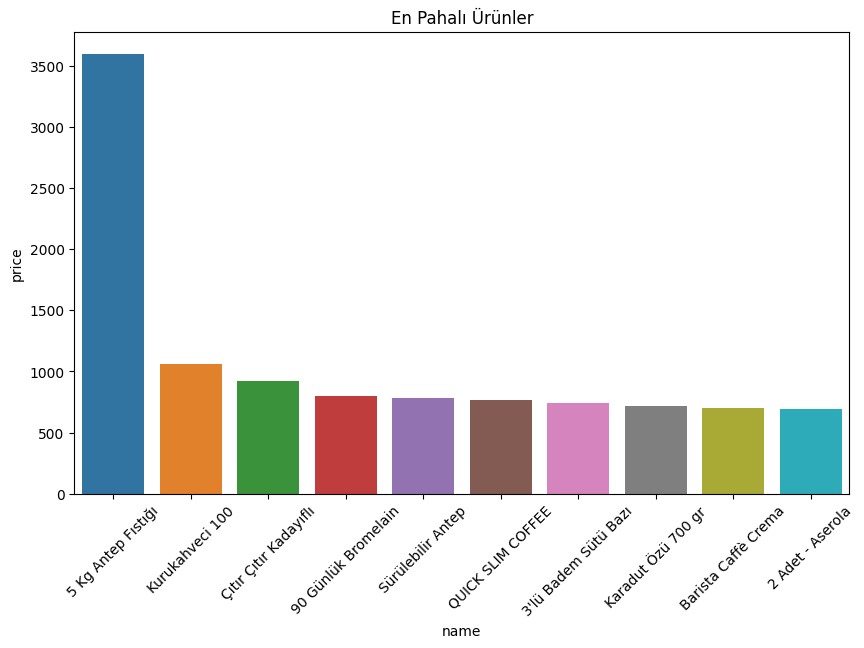

In [130]:

plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='price', data=most_expensive)
plt.title('En Pahalı Ürünler')
plt.xticks(rotation=45)
plt.show()



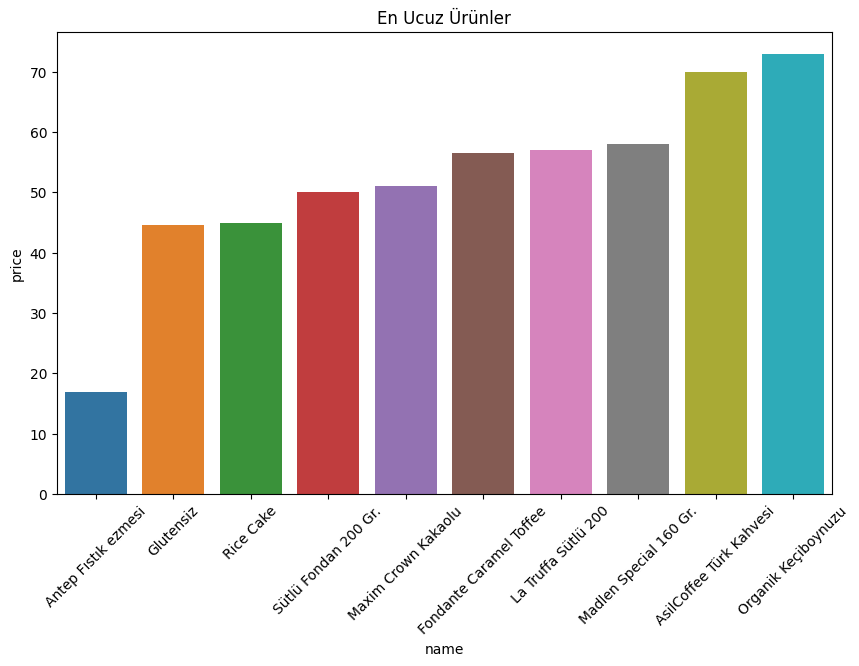

In [131]:
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='price', data=cheapest)
plt.title('En Ucuz Ürünler')
plt.xticks(rotation=45)
plt.show()

### Analiz 3: En yüksek puana sahip ürünler

In [122]:
highest_rated = df.nlargest(10, 'rating_score')

highest_rated

,productid,brand,name,price,category,description,comment_count,rating_score
0,815909040,Melek Ana,Kids Çocuklar için,389.0,Gıda ve İçecek,"Özel Kakaolu, Arı sütlü, Vitaminli, İştah Açıc...",578,5.0
2,829692875,Setamell,Kilo Aldırıcı Iştah,374.0,Gıda ve İçecek,Açıcı ( Çikolata Aromalı Toz ),141,5.0
4,829926931,Doree Beaute,Kilo aldırıcı,305.0,Gıda ve İçecek,iştah açıcı çikolata aromalı toz 230 gr,324,5.0
5,740791254,Caffe Del Bello,Nikaragua,110.0,Gıda ve İçecek,Filtre Kahve 250 Gr. (ÇEKİRDEK VEYA ÖĞÜTÜLMÜŞ),13,5.0
6,830430088,Doree Beaute,Detox yardımcı,270.0,Gıda ve İçecek,bitkisel çay 1 li sets,198,5.0
14,830430329,Doree Beaute,Detox yardımcı,370.0,Gıda ve İçecek,bitkisel çay 2 li set,150,5.0
28,740788349,Caffe Del Bello,Espresso,400.0,Gıda ve İçecek,Special Blend 1 Kg. (ÇEKİRDEK VEYA ÖĞÜTÜLMÜŞ),11,5.0
53,679421582,Genel Markalar,Çarşıbaşı,370.0,Gıda ve İçecek,Sütlü Yumurtacık Bayram Çikolatası 350g,3,5.0
62,828140419,Unova,ANTAKYA ÇİFTE KAVRULMUŞ,340.0,Gıda ve İçecek,TÜRK KAHVESİ 1000 G,4,5.0
84,814545931,Dr Life Esthetic,Happy Lady,318.0,Gıda ve İçecek,Civan Perçemli Rahatlatıcı Özel Gün Bitki Çayı,28,5.0


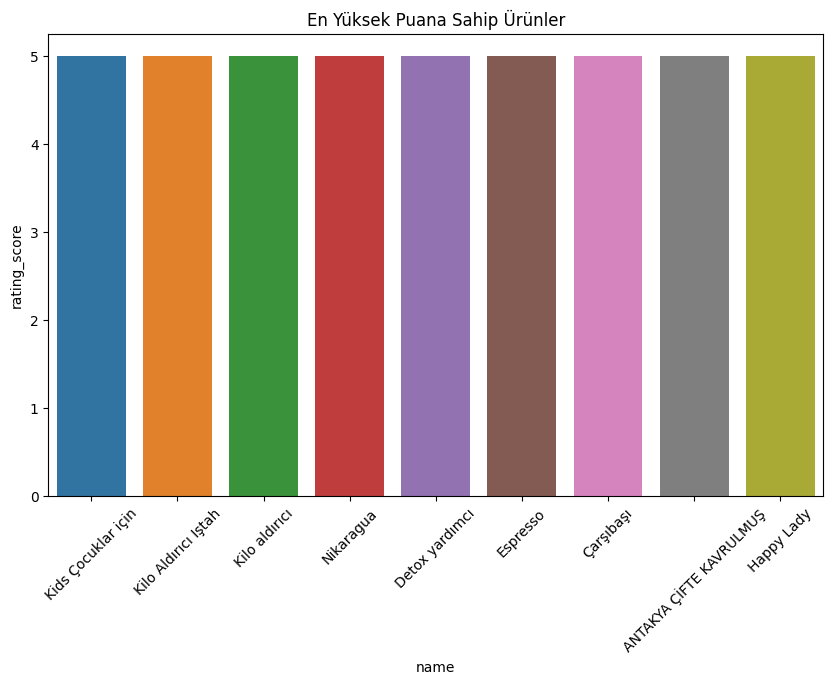

In [132]:
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='rating_score', data=highest_rated)
plt.title('En Yüksek Puana Sahip Ürünler')
plt.xticks(rotation=45)
plt.show()

### Analiz 4: En çok yorum alan ürünler

In [125]:
most_commented = df.nlargest(10, 'comment_count')

most_commented

,productid,brand,name,price,category,description,comment_count,rating_score
69,130593681,Zühre Ana,Kids Çocuklar için,229.90,Gıda ve İçecek,"Özel - Arı Sütü, Pekmez, Bal Ve Vitamin Katkıl...",63199,4.7
115,49226069,Zühre Ana,Kozalak Macunu -,199.90,Gıda ve İçecek,Çam Kozalağı Macunu Hologramlı Ürün,48930,4.7
10,712245449,Zühre Ana,Karadut Özü 670 Gr,219.90,Gıda ve İçecek,None,46955,4.6
51,449040367,Dr Tayyaröz,Çocuk Macunu,159.00,Gıda ve İçecek,-kakao Propolis Pekmez Arı Sütü Bal Ve Vitamin,43550,4.6
1,37808818,Kb Köyceğiz Yöresel,Karadut,290.00,Gıda ve İçecek,Özü 1000 G,27224,4.8
161,130559824,Züber,Fıstık Ezmesi 3 Adet X,345.80,Gıda ve İçecek,315 gr,23616,4.6
58,288620006,Harmana,Hindiba Kahvesi Detox,277.85,Gıda ve İçecek,Kahve 1 Aylık - (60 KULLANIM) Net 150gr,23209,4.4
35,653532785,Narcissa,Aserola Ekstresi,399.00,Gıda ve İçecek,içeren Karışık Bitki Tozu,22229,NaN
83,447419994,Dr Tayyaröz,Doğal Keçi,115.00,Gıda ve İçecek,Boynuzu Pekmezi 320 Gram,20406,4.6
107,3674890,Kahve Dünyası,Orta Kavrulmuş,399.00,Gıda ve İçecek,Türk Kahvesi 100 gr - 12'li,20116,4.7


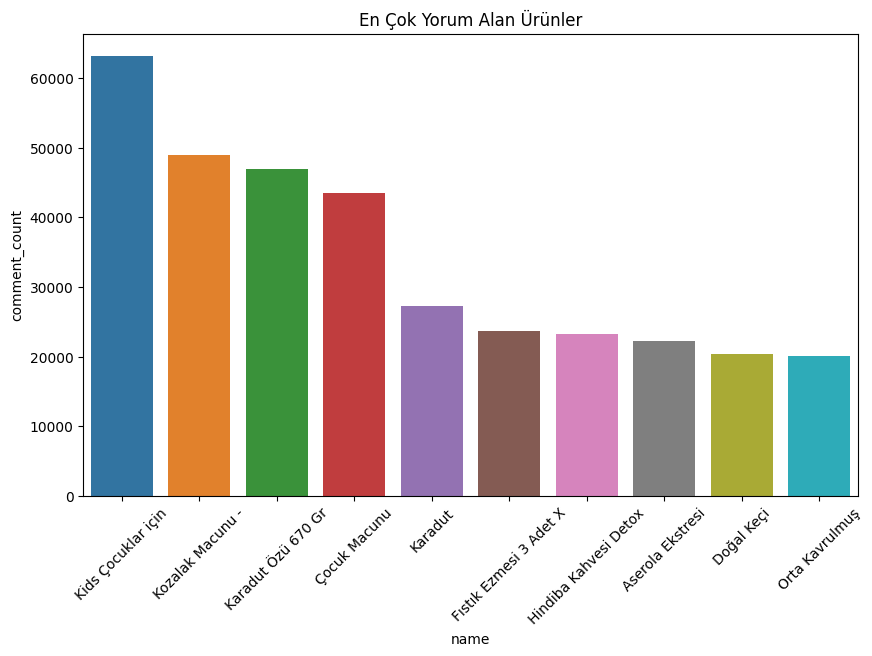

In [134]:
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='comment_count', data=most_commented)
plt.title('En Çok Yorum Alan Ürünler')
plt.xticks(rotation=45)
plt.show()

### Analiz 5: Markalara göre ortalama fiyatlar


In [126]:

average_price_by_brand = df.groupby('brand')['price'].mean().reset_index()

average_price_by_brand

,brand,price
0,Abdurrahman Tatlıcı,341.900000
1,Addis Ababa Coffee,306.500000
2,Alsancak Kuru Kahvecisi 1967'Den Beri,372.000000
3,Anisah Coffee,317.900000
4,Antebella,267.500000
...,...,...
157,Wi̇shay Beauty Cosmeti̇c,400.000000
158,Zadelife,200.666667
159,Züber,247.922727
160,Zühre Ana,226.637692


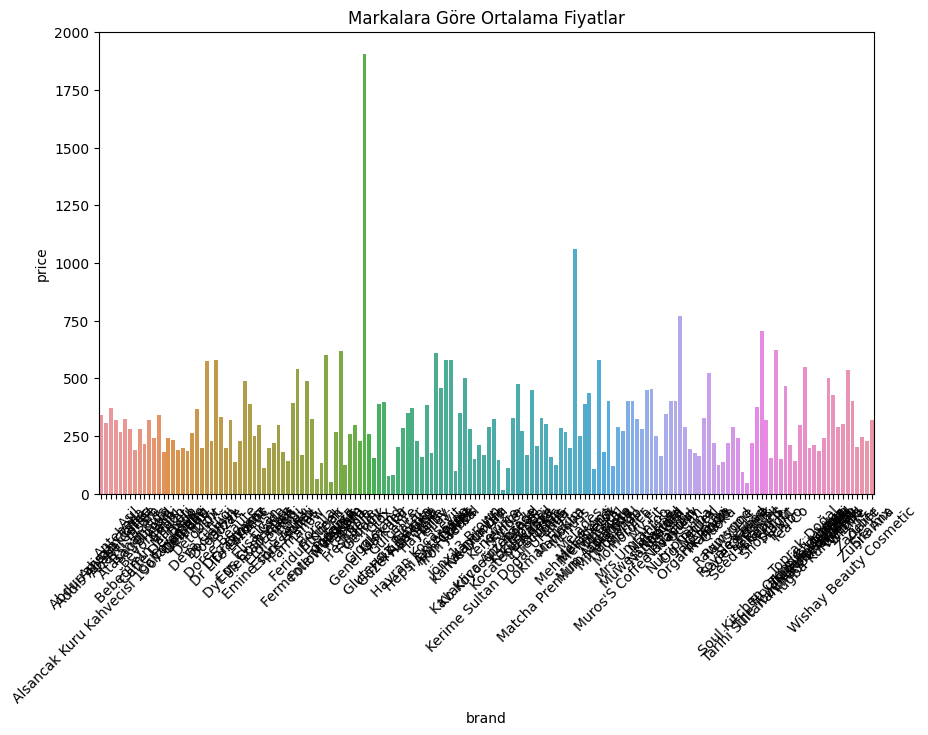

In [138]:
plt.figure(figsize=(10, 6))
sns.barplot(x='brand', y='price', data=average_price_by_brand)
plt.title('Markalara Göre Ortalama Fiyatlar')
plt.xticks(rotation=45)
plt.show()

### Ürün fiyat dağılımı

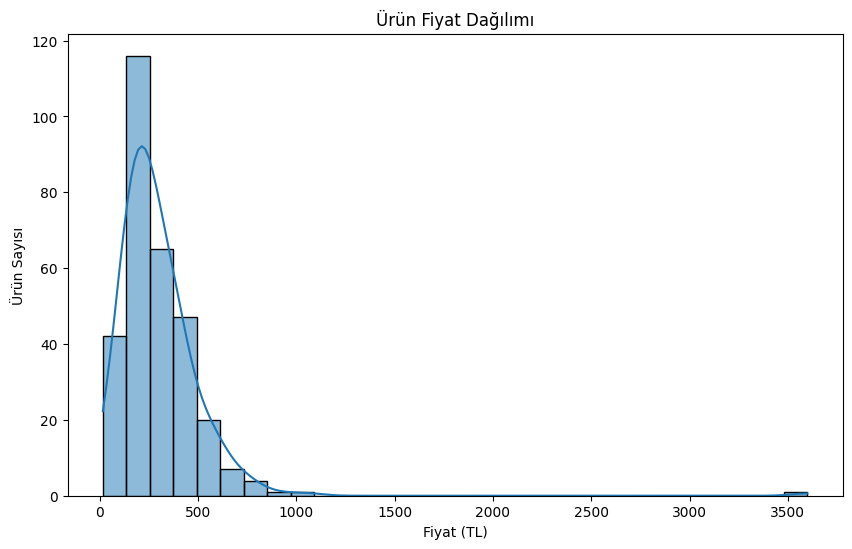

In [139]:
# Fiyat dağılım grafiği
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Ürün Fiyat Dağılımı')
plt.xlabel('Fiyat (TL)')
plt.ylabel('Ürün Sayısı')
plt.show()


#  Fiyat ve yorum sayısı arasındaki ilişki

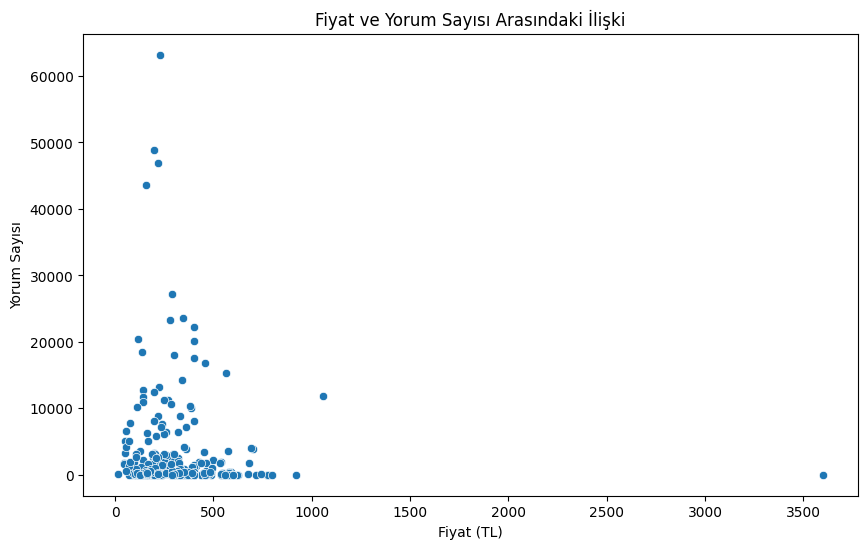

In [141]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='comment_count', data=df)
plt.title('Fiyat ve Yorum Sayısı Arasındaki İlişki')
plt.xlabel('Fiyat (TL)')
plt.ylabel('Yorum Sayısı')
plt.show()


# Ortalama puan ve fiyat arasındaki ilişki

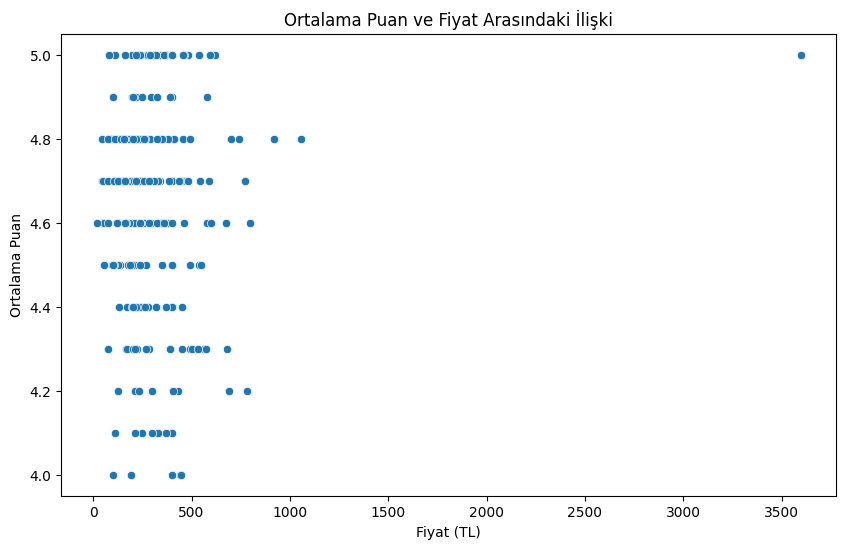

In [142]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='rating_score', data=df)
plt.title('Ortalama Puan ve Fiyat Arasındaki İlişki')
plt.xlabel('Fiyat (TL)')
plt.ylabel('Ortalama Puan')
plt.show()
